# Test space.

In [66]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/Users/Jake/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

# Neat tricks.
from itertools import chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Local imports. 
from PyUtils.Utils_Files import makeDirs, make_str_title_friendly, check_overwrite
from PyUtils.Utils_Plotting import (change_cmap_bkg_to_white, save_plots_to_outpath, make_1D_dist, get_stats_1Dhist, 
                                    get_stats_2Dhist, hist_y_label, make_2by2_subplots_for_ratioplots,
                                    add_underoverflow_entries, make_stats_legend_for_1dhist, make_stats_legend_for_2dhist, 
                                    make_stats_legend_for_gaus_fit)
from PyUtils.Utils_Physics import theta2pseudorap, pseudorap2theta, calc_dR, calc_dphi, perc_diff
from PyUtils.Utils_StatsAndFits import gaussian, fit_with_gaussian, iterative_fit_gaus
from PyUtils.Utils_Collection_Helpers import weave_lists
from d0_Utils.d0_cls import KinematicBin, KinBinOrganizer, GraphLine
from d0_Utils.d0_fns import (make_binning_array, shift_binning_array, get_subset_mask, 
                             make_kinem_subplot, calc_x_err_bins, combine_cut_list, calc_bin_widths)
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

plt.rcParams.update({'figure.max_open_warning': 10})    # Related to saving memory and opening plots.

# pd.options.display.max_columns = 23
pd.options.display.max_columns = None

plt.style.use('cmsstyle_plot')
# plt.style.use("grid_multiple_plots")

ImportError: cannot import name 'perc_diff' from 'PyUtils.Utils_Physics' (/Users/Jake/HiggsMassMeasurement/PyUtils/Utils_Physics.py)

In [2]:
%%time
infile_path_MC_2016 = '/Users/Jake/Desktop/MC_2016.h5'
infile_path_MC_2017 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2017.feather'
infile_path_MC_2018 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2018.feather'

# df_MC_2016 = pd.read_feather(infile_path_MC_2016)
# df_MC_2017 = pd.read_feather(infile_path_MC_2017)
# df_MC_2018 = pd.read_feather(infile_path_MC_2018)

df_MC_2016 = pd.read_hdf(infile_path_MC_2016)
# df_MC_2017 = pd.read_hdf(infile_path_MC_2017)
# df_MC_2018 = pd.read_hdf(infile_path_MC_2018)

CPU times: user 260 ms, sys: 6.63 s, total: 6.89 s
Wall time: 15.7 s


In [3]:
class KinBinOrganizer():
    """
    Creates and organizes KinematicBin objects which all have exactly the same cuts, except for d0 cuts. 
    """
    def __init__(self, 
                 df, 
                 n_evts_scan=1000, 
                 massZ_cut_ls=[60,120],
                 eta_cut_ls=[0.0, 0.3], 
                 pT_cut_ls=[20, 60], 
                 d0_type='BS', 
                 dR_cut=0.05, 
                 use_ptotal_instead=False, 
                 verbose=True):
        """
        These cuts will apply to all KinematicBin objects within this KinBinOrganizer container.
        """
        self.df = df 
        self.n_evts_scan = n_evts_scan
        self.massZ_cut_ls = massZ_cut_ls
        self.eta_cut_ls = eta_cut_ls
        self.pT_cut_ls = pT_cut_ls
        self.d0_type = d0_type
        self.dR_cut = dR_cut
        self.use_ptotal_instead = use_ptotal_instead
        self.verbose = verbose
        
    def make_kbin_ls_over_d0_range(self, d0_bin_limits):
        """
        Make a list of KinematicBin objects, all with identical cuts EXCEPT d0q cuts. 
        """
        d0_bin_arr, d0_bin_width = make_binning_array(d0_bin_limits)
        
        if d0_bin_width < 0.0005:
            err_msg = f"WARNING: d0_bin_width ({d0_bin_width}) is too small (d0_bin_width < 0.0005).\nStopping now."
            raise ValueError(err_msg)    
            
        self.d0_bin_arr = d0_bin_arr
        self.d0_bin_arr_shifted = shift_binning_array(d0_bin_arr)
        
        kbin_ls = []
        for elem in range(len(d0_bin_arr)-1):
            # Make a kbin for each d0 bin.
            d0_this = d0_bin_arr[elem]
            d0_next = d0_bin_arr[elem+1]

            kb = KinematicBin(df_original=self.df, 
                              n_evts=self.n_evts_scan, 
                              massZ_cut_ls=self.massZ_cut_ls,
                              eta_cut_ls=self.eta_cut_ls, 
                              pT_cut_ls=self.pT_cut_ls, 
                              d0q_cut_ls=[d0_this, d0_next],
                              d0_type=self.d0_type,
                              dR_cut=self.dR_cut,
                              use_ptotal_instead=self.use_ptotal_instead, 
                              verbose=self.verbose)
            kbin_ls.append(kb)
            
        self.kbin_ls = kbin_ls

    def plot_dpToverpT_for_kbin_ls(self, kinem="delta_pToverpT1", lep_selection_type='independent', 
                                   x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], 
                                   run_over_only_n_evts=-1, 
                                   ax=None, y_max=-1, log_scale=False, 
                                   iter_gaus=(False, 3),
                                   make_pdf=False, pdf_obj=None ):
        """
        The main purpose of making these plots is to fill the stats_dict for each kbin.
        
        Parameters
        ----------
        make_pdf : 
        
        """
        for kb in self.kbin_ls:
            kb.plot_1D_kinematics(kinem=kinem, lep_selection_type=lep_selection_type, 
                                  x_limits=x_limits, bin_limits=bin_limits, run_over_only_n_evts=run_over_only_n_evts, 
                                  ax=ax, x_label="", y_label="", title="", y_max=y_max, log_scale=log_scale, 
                                  iter_gaus=iter_gaus)
            if (make_pdf):
                pdf_obj.savefig()
            plt.close()
        # All kbins have filled their stats_dict.
            
#     def get_dpToverpT_iter_gaus_fit_means(self, kinem):
    def get_iter_gaus_fit_stats(self, kinem):
        """"""
        # Get graph values.
        self.hist_mean_ls     = []
        self.hist_mean_err_ls = []
        self.fit_mean_ls      = []
        self.fit_mean_err_ls  = []
        
        for kb in self.kbin_ls:
#             self.hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
#             self.hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
#             self.fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
#             self.fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])
            self.hist_mean_ls.append(kb.stats_dict[kinem]['hist_stats'][1])
            self.hist_mean_err_ls.append(kb.stats_dict[kinem]['hist_stats'][2])
            self.fit_mean_ls.append(kb.stats_dict[kinem]['fit_stats']['mean_ls'][-1])
            self.fit_mean_err_ls.append(kb.stats_dict[kinem]['fit_stats']['mean_err_ls'][-1])
            
class GraphLine():
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    def __init__(self, x_vals, y_vals, y_err_vals=np.zeros(0)):
        self.x_vals = x_vals
        self.y_vals = y_vals
#         self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
    def draw_graph(self, kinem_x, kinem_y, x_label="", y_label="", binning_type="", kbin_example=None, ax=None, count=1):
        """
        Draws data points (values of: kinem_x, kinem_y) to an axes object. 
        In particular, used for making dpT/pT vs. d0q plots, but could probably be generalized.
        
        Parameters
        ----------
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        x_label : str
            The x-axis label. If no x_label is given, then an automatic one 
            is generated based on kinem_x.
        y_label : str
            The y-axis label. If no y_label is given, then an automatic one 
            is generated based on kinem_y.
        binning_type : str
            Must be either 'eta' or 'pT'. Used for proper labeling of title and legend.
        kbin_example : KinematicBin object
            This KinematicBin contains all the cut information necessary for proper
            legend and axes labeling.
        ax : axes object
            The axes on which to draw the graph. 
            If an axes is not provided, a default one is made.
        count : int
            A key to a dictionary of colors. 
            Values of the dict are color strings, like: 'black', 'red', etc. 
        """
        if binning_type not in ["eta", "pT"]:
            raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
#         #--- Check that things make sense: ---#
#         # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
#         wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
#         # Do same thing for binning in pT.
#         wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
#         if (wrong_eta_binning or wrong_pT_binning):
#             err_msg = f"\n\nBinning type ({binning_type}) specified, "
#             err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
#             raise RuntimeError(err_msg)

        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ms=4  # marker size
        ecolor=color_dict[count]
        mec=color_dict[count]  # Marker edge color.
        mfc=color_dict[count]  # Marker face color.
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = label_LaTeX_dict[kinem_x]["independent_label"]
            unit_x = label_LaTeX_dict[kinem_x]["units"]
            if len(unit_x) > 0:
                x_label += " [{}]".format(unit_x)
        if len(y_label) == 0:
            y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
            y_label += " (iterated Gaus fit mean)"
        title = label_LaTeX_dict[binning_type + "1"]["independent_label"] + " Binning"
#         if binning_type == "eta":
#             title = r"$\left| $" + title + r"$\right| $"
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
        low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        label_text = kbin_example.cut_dict[binning_type]
        if (kbin_example.verbose):
            print("Drawing graph, binning in {}:".format(binning_type))
            print(kbin_example.cut_dict[binning_type] + "\n")
        ax.errorbar(self.x_vals, self.y_vals, xerr=[low_x_err, high_x_err], yerr=self.y_err_vals, fmt='s', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, mec=mec, capsize=cs, mew=mew, mfc=mfc, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
        tmp_dict = kbin_example.cut_dict.copy()
        for key in list(kbin_example.cut_dict.keys()):
            if (binning_type in key) or ("d0" in key):
                del tmp_dict[key]
                    
        sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
        cut_str = combine_cut_list(sorted_cut_ls)
        textbox_text = "Selections:\n" + cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        
        if count == 1:
            ax.text(0.05, 0.85, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
    def do_linear_fit(self, ax=None):
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8,9.6)) 
        
        # Do fit. 
        # Draw fit on axes.
        # return optimized parameters
        self.popt_linear = None

# Make $p_T$ distributions in different $\eta$ bins.

In [ ]:
kbin = KinematicBin(df_MC_2016, 
                    n_evts=10000, 
                    massZ_cut_ls=[60,120],
                    eta_cut_ls=[0.0, 0.3], 
                    pT_cut_ls=[40, 50], 
                    d0q_cut_ls=[-0.005, 0.005],
                    d0_type='BS',
                    dR_cut=0.02,
                    use_ptotal_instead=False, 
                    verbose=True)

In [42]:
%%time
%config InlineBackend.figure_format = 'retina'
# f, ax = plt.subplots(figsize=(12.8,9.6))

n_evts_scan = 2000000
# n_evts_scan = 300000
n_evts_keep = 1000000

df = df_MC_2016
d0_bin_limits = [-1, 1, 2]
massZ_cut_ls=[60,120]
pT_cut_ls=[5,1000]
eta_cut_ls=[
    [0.0, 0.2],
    [0.2, 0.4],
    [0.4, 0.6],
    [0.6, 0.8],
    [0.8, 1.0],
    [1.0, 1.2],
    [1.2, 1.4],
    [1.4, 1.6],
    [1.6, 1.8],
    [1.8, 1.9],
    [1.9, 2.0],
    [2.0, 2.1],
    [2.1, 2.2],
    [2.2, 2.3],
    [2.3, 2.4],
]

d0_type='BS'
dR_cut=0.008
use_ptotal_instead=False
fit_iters = 3

# outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_distributions_eta_binning/DY_MC_2016_3Mevts.pdf"
outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/pT_distributions_eta_binning/test_09.pdf"
overwrite = True
verbose = True

#--- Automatons ---#
dir_ = os.path.dirname(outpath)
check_overwrite(outpath, overwrite)
makeDirs(dir_) 

org_kbin_ls = []
with PdfPages(outpath) as pdf:
    for eta_reg_ls in eta_cut_ls: 
        org_kbin = KinBinOrganizer(df, n_evts_scan, massZ_cut_ls, eta_reg_ls, pT_cut_ls, d0_type, dR_cut, use_ptotal_instead, verbose)
        org_kbin.make_kbin_ls_over_d0_range(d0_bin_limits)
        org_kbin.plot_dpToverpT_for_kbin_ls(kinem="pT1", lep_selection_type='independent', 
                                           x_limits=[-40, 250], bin_limits=[5, 200, 1], 
                                           run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, 
                                           iter_gaus=(False, fit_iters),
                                           make_pdf=True,
                                           pdf_obj=pdf    # If make_pdf=True, must pass in pdf object here!
                                           )  
#         org_kbin.get_iter_gaus_fit_stats("pT1")

        org_kbin_ls.append(org_kbin)
        plt.close("all")
    # Done looping over all eta regions.
    
    # Plot all graph lines on single axes. 
#     graph_ls = []
#     f, ax = plt.subplots()
#     for count,org_kb in enumerate(org_kbin_ls, 1):
#         graph = GraphLine(org_kb.d0_bin_arr_shifted, org_kb.fit_mean_ls, org_kb.fit_mean_err_ls)
#         graph.draw_graph("d0BSq1", "delta_pToverpT1", binning_type=binning_type, kbin_example=org_kb.kbin_ls[0], ax=ax, count=count)
#         # Note: if you want stats to show up on plot when doing draw_graph, then make sure count=1 at some point.
#         graph_ls.append(graph)
#     # Done looping over KinBinOrganizers.
#     plt.tight_layout()
#     pdf.savefig()
#     plt.close("all")

[INFO] Events found: 376075 (18.804% of total events scanned)
using cuts: $-1.000 < d_{0}^{\mathrm{BS}}*q(\mu) < 1.000$
$\Delta R < 0.008$
$0.00 < \left| \eta^{\mathrm{REC}} \right| < 0.20$
$60.0 < m_{\mu\mu} < 120.0$ GeV
$5 <$ $p_{T}^{\mathrm{REC}}$ $< 1000$ GeV

[INFO] Events found: 373297 (18.665% of total events scanned)
using cuts: $-1.000 < d_{0}^{\mathrm{BS}}*q(\mu) < 1.000$
$\Delta R < 0.008$
$0.20 < \left| \eta^{\mathrm{REC}} \right| < 0.40$
$60.0 < m_{\mu\mu} < 120.0$ GeV
$5 <$ $p_{T}^{\mathrm{REC}}$ $< 1000$ GeV

[INFO] Events found: 366476 (18.324% of total events scanned)
using cuts: $-1.000 < d_{0}^{\mathrm{BS}}*q(\mu) < 1.000$
$\Delta R < 0.008$
$0.40 < \left| \eta^{\mathrm{REC}} \right| < 0.60$
$60.0 < m_{\mu\mu} < 120.0$ GeV
$5 <$ $p_{T}^{\mathrm{REC}}$ $< 1000$ GeV

[INFO] Events found: 357455 (17.873% of total events scanned)
using cuts: $-1.000 < d_{0}^{\mathrm{BS}}*q(\mu) < 1.000$
$\Delta R < 0.008$
$0.60 < \left| \eta^{\mathrm{REC}} \right| < 0.80$
$60.0 < m_{\mu\

In [61]:
# DON'T COPY THIS INTO UTILS_PHYSICS! It's already there.

def perc_diff(num, ref):
    """
    Return the signed percent difference between two numbers, relative to one of them.
    
    Parameters
    ----------
    num : float
        New number to which you want to compare to the reference number (ref).
        If num < ref, then will return a negative percent difference.
    ref : float
        Reference number. Goes in the denominator.
    """
    return (num - ref) / ref * 100.

In [ ]:
def find_equal_hist_divisions(bin_edges, bin_vals, K, verbose=False):
    """
    Return the bin edges which divide the histogram into divisions with equal entries per division. 
    
    Algorithm example:
        Want to split histogram of 100 entries up into 3 divisions. 
        Calculate hypothetical entries_per_division: 100/3 = 33.333.
        Start from first bin and keep adding bin entries until you exceed entries_per_division. 
        Record this bin edge. 
        Do only 2 scans over the first two divisions.
        Third division is found by deduction.
    
    Parameters
    ----------
    bin_edges : list or array-like
        
    K : int
        Number of divisions of area of hist, such that each division contains the same number of entries. 
        
    Returns
    -------
    bin_div_ls : list
        A list of the edges of each division along the x-axis. 
        The number of entries between divisions should have ~same number of entries, 
        (up to a User-specified window? Say 0.1% of true entries_per_div?)
        
    Notes:
    Should be the case that: len(bin_edges) == len(bin_vals) + 1
    """
    

    def compare_neighboring_bins(bin_val_arr, elem_start, elem_end, true_sum):
        """
        Returns the index of bin_edges which gives the smaller abs(% difference).
        """
        # This element corresponds to the last bin which would not exceed true_sum.
        prev_elem = elem_end - 1
        
        this_sum = np.sum(bin_val_arr[elem_start:elem_end+1])
        prev_sum = np.sum(bin_val_arr[elem_start:prev_elem+1])
        
        this_perc_diff = perc_diff(this_sum, true_sum)
        prev_perc_diff = perc_diff(prev_sum, true_sum)
        
        # Return element coresponding to smaller percent difference. 
        print("[INFO]    this_perc_diff ({}%) vs. prev_perc_diff ({}%)".format(this_perc_diff, prev_perc_diff))
        if abs(this_perc_diff) < abs(prev_perc_diff):
            print("[INFO]    elem_end ({}) gave the lesser perc. diff: {}%".format(elem_end, this_perc_diff))
            return elem, this_sum, this_perc_diff
        else:
            print("[INFO]    prev_elem ({}) gave the lesser perc. diff: {}%".format(prev_elem, prev_perc_diff))
            return prev_elem, prev_sum, prev_perc_diff
    

    
    
    entries_total = np.sum(bin_vals)
    entries_per_div = entries_total / float(K)
    bin_div_ls = [bin_edges[0]]  
    bin_stats_dict = {}
    
    if (verbose): 
        print("[INFO] Performing {} divisions on {} total entries.".format(K, entries_total))
#         print("[INFO] Expecting {} entries per division...".format(entries_per_div))
    last_div_elem = -1  # Don't touch! It needs to start at -1 because of indexing madness.
    elem = 0
    tmp_total_entries = 0
    # Loop over all divisions, except last.
    for count in range(1,K+1):
        if (count == K) and (count != 1): break
        if (verbose): print("[INFO]  Division {}: Looking for {:.2f} entries".format(count, entries_per_div))
        
        sum_entries = -1
        last_div_elem += 1
#         try:
        while True:
            # Find the element of the bin which meets or exceeds the entries_per_div.
            div_bin_vals = bin_vals[last_div_elem:elem+1]  # Have to add 1, since Python excludes right bound in slice.
            sum_entries = np.sum(div_bin_vals)  
#                 print("loop {}: sum_entries ({}) vs. entries_per_div ({})".format(loop,sum_entries, entries_per_div))
            if sum_entries >= entries_per_div:
                break
            else:
                elem +=1
#         except IndexError:
#             print("\n[!!!WARNING!!!] Could not find {:.2f} entries in division {}.".format(entries_per_div, count))
#             print("  This is an artifact of the bin size. Try fewer than {} divisions.".format(K))
#             return bin_div_ls

#         print("Before comparing neighbors: elem={}, sum_entries={}\ndiv_bin_vals={}".format(elem,sum_entries,div_bin_vals))
        # Now see if previous bin was a better decision, by taking the lesser percent difference. 
        elem, sum_entries, perc_diff_div = compare_neighboring_bins(bin_vals, last_div_elem, elem, entries_per_div)
        # Found the best element, sum, and perc diff which correspond to this division bin. 
        if (verbose): print("[INFO]    Found {} entries ({:.4f}% than was searched for)".format(sum_entries, perc_diff_div))
        bin_stats_dict["Division{}".format(count)] = perc_diff_div
#         print("[INFO]    last_div_elem before update: {}".format(last_div_elem))
        last_div_elem = elem
#         print("[INFO]    last_div_elem AFTER update: {}".format(last_div_elem))
        bin_div = bin_edges[elem]
        if (verbose): print("[INFO]    Dividing bin is: {}\n".format(bin_div))
        bin_div_ls.append(bin_div)
        # Start the next division at the element that we stopped at last. 
        # So don't change the counting of elem.
        
        tmp_total_entries += sum_entries
    # All divisions, except last, performed successfully.
    # Since last division isn't performed, append final bin.
    bin_div_ls.append(bin_edges[-1])
    
    # Find number of entries remaining in last division. 
    excess_entries = np.sum(bin_vals[elem+1:])  # This slice will exclude the FIRST value (elem), oddly enough.
    perc_diff_excess = perc_diff(excess_entries, entries_per_div)
    tmp_total_entries += excess_entries
    if (verbose): 
        print("[INFO]  Division {} was analyzed by deduction.".format(K)) 
        print("[INFO]    Excess entries in this division: {} ({:.4f}% different from number searched for)".format(excess_entries, perc_diff_excess))
        print("[INFO]    Final bin division list is:\n{}".format(bin_div_ls))
        print("Total entries found: {}".format(tmp_total_entries))
    bin_stats_dict["Division{}".format(K)] = perc_diff_excess
    
    return bin_div_ls, bin_stats_dict

In [283]:
def find_equal_hist_divisions(bin_edges, bin_vals, K, verbose=False):

    entries_total = np.sum(bin_vals)
    entries_per_div = entries_total / float(K)
    bin_div_ls = [bin_edges[0]]  # This is what we are after ultimately. 
    bin_stats_dict = {}
    
    if (verbose): 
        print("[INFO] Performing {} divisions on {} total entries.".format(K, entries_total))
    
    start_elem = 0
    # Always do K - 1 loops, except when K = 1. 
    div_ls = [1] if K == 1 else list(range(1,K))
    
    tmp_division_entries = 0
    for count in div_ls:
        print("[INFO]  Beginning division {}...".format(count))
        
        end_elem = start_elem + 1
        while True:
#             print("[INFO]    start_elem, end_elem: {}, {}".format(start_elem,end_elem))
            division_bin_edges = bin_edges[start_elem:end_elem+1]  # Extra 1 because of Python's exclusion.
            division_bin_vals = bin_vals[start_elem:end_elem]
            division_entries, first_bin_left_edge, last_bin_right_edge = integrate_hist_over_region(division_bin_edges, division_bin_vals)
#             print("[INFO]  Integration performed.")
#             print("[INFO]    division_bin_edges:",division_bin_edges)
#             print("[INFO]    division_bin_vals:",division_bin_vals)
#             print("[INFO]    division_entries, first_bin_left_edge, last_bin_right_edge:\n",division_entries, first_bin_left_edge, last_bin_right_edge)
            if division_entries >= entries_per_div: 
#                 print("[INFO]    Breaking out of while loop with end_elem = {}".format(end_elem))
                break
            else:
                end_elem += 1
        
        print("[INFO]    Found {} entries when looking for {}.".format(division_entries, entries_per_div))
        # Check if previous bin would have been a better choice. 
        prev_division_bin_edges = bin_edges[start_elem:end_elem]
        prev_division_bin_vals = bin_vals[start_elem:end_elem-1]
        prev_division_entries, prev_first_bin_left_edge, prev_last_bin_right_edge = integrate_hist_over_region(prev_division_bin_edges, prev_division_bin_vals)
#         print("[INFO]  Checking up to previous element...")
#         print("[INFO]    prev_division_bin_edges:\n",prev_division_bin_edges)
#         print("[INFO]    prev_division_bin_vals:\n",prev_division_bin_vals)
#         print("[INFO]    prev_division_entries, prev_first_bin_left_edge, prev_last_bin_right_edge:\n",prev_division_entries, prev_first_bin_left_edge, prev_last_bin_right_edge)
        
        div_perc_diff = perc_diff(division_entries, entries_per_div)
        prev_div_perc_diff = perc_diff(prev_division_entries, entries_per_div)
        if abs(div_perc_diff) < abs(prev_div_perc_diff):
            best_div_entries = division_entries
            best_perc_diff = div_perc_diff
            best_bin_edge = last_bin_right_edge
            best_div_bin_edges = division_bin_edges
            best_div_bin_vals = division_bin_vals
            # Keep end_elem where it is.
#             print("[INFO]    div_perc_diff gave the lesser perc. diff ({:.4f}%), compared to ({:.4f}%)".format(div_perc_diff,prev_div_perc_diff))
        else:
            best_div_entries = prev_division_entries
            best_perc_diff = prev_div_perc_diff
            best_bin_edge = prev_last_bin_right_edge
            best_div_bin_edges = prev_division_bin_edges
            best_div_bin_vals = prev_division_bin_vals
            # Need to decrement end_elem. 
            end_elem -= 1
#             print("[INFO]    prev_div_perc_diff gave the lesser perc. diff ({:.4f}%), compared to ({:.4f}%)".format(prev_div_perc_diff,div_perc_diff))
                
        if (verbose): 
#             print("[INFO]    Best right edge found: {}".format(best_bin_edge))
            print("[INFO]    best_div_entries, best_perc_diff, best_bin_edge: {}, {}, {}".format(best_div_entries,best_perc_diff,best_bin_edge))
            print("[INFO]    best_div_bin_edges\n", best_div_bin_edges)
            print("[INFO]    best_div_bin_vals\n", best_div_bin_vals)
#             print("[INFO]    Found {} entries ({:.4f}% than was searched for)".format(best_div_entries, best_perc_diff))
#             print("[INFO]    best end_elem was found to be {}".format(end_elem))
                
        # Found the best element, sum, and perc diff which correspond to this division bin. 
        bin_stats_dict["Division{} perc diff".format(count)] = best_perc_diff
        bin_div = bin_edges[end_elem]  # Looks right.
#         if (verbose): print("[INFO]    Dividing bin is: {}\n".format(bin_div))
        bin_div_ls.append(bin_div)
        # Start the next division at the element that we stopped at last. 
        # So don't change the counting of elem.
        start_elem = end_elem
        
        tmp_division_entries += best_div_entries
    # All divisions, except last, performed successfully.
    # Since last division isn't performed, append final bin.
    if K != 1:
        bin_div_ls.append(bin_edges[-1])
    
    # Find number of entries remaining in last division. 
    last_bin_edges = bin_edges[end_elem:] # Can delete.
    last_bin_vals = bin_vals[end_elem:] # Can delete.

    excess_entries = np.sum(bin_vals[end_elem:])
    perc_diff_excess = perc_diff(excess_entries, entries_per_div)
    tmp_division_entries += excess_entries
    if (verbose): 
        print("[INFO]  Division {} was analyzed by deduction.".format(K)) 
        print("[INFO]    Excess entries in this division: {} ({:.4f}% different from number searched for)".format(excess_entries, perc_diff_excess))
        print("[INFO]    last_bin_edges\n",last_bin_edges)
        print("[INFO]    last_bin_vals\n",last_bin_vals)
        print("[INFO]    Final bin division list is:\n{}".format(bin_div_ls))
        print("Total entries found: {}".format(tmp_division_entries))
    bin_stats_dict["Division{}".format(K)] = perc_diff_excess
    
    return bin_div_ls, bin_stats_dict


def integrate_hist_over_region(bin_edges, bin_vals):
    """
    Calculate the total area of a histogram over the specified bin_edges.
    Performs a simple width * height calculation for each bin area, then sums up all areas. 
    
    Parameters
    ----------
    bin_edges : array
        The boundaries of all the bins. They can be variable bin widths.
        E.g., np.array([first_bin_left_edge, first_bin_right_edge, ..., last_bin_left_edge, last_bin_right_edge])
    bin_vals : array
        An array which contains the entries in each bin.
        len(bin_vals) = len(bin_edges) - 1
        
    Returns
    -------
    total_area : float
        Usually the total entries of all bins being summed.
    first_bin_left_edge : float
        Where the summing started along the x-axis, in x-axis units.
    last_bin_right_edge : float
        Where the summing ended along the x-axis, in x-axis units.
    """
    first_bin_left_edge = bin_edges[0]
    last_bin_right_edge = bin_edges[-1]
    
    # Area calculation
    bin_width_arr = calc_bin_widths(bin_edges)
    total_area = np.sum(bin_width_arr * bin_vals)
    
    return total_area, first_bin_left_edge, last_bin_right_edge

def calc_bin_widths(bin_edges):
    """
    Return an array which contains the bin widths of each bin. 
    Bins can be of unequal widths. 
    
    Parameters
    ----------
    bin_edges : array
        The boundaries of all the bins. They can be variable bin widths.
        E.g., np.array([first_bin_left_edge, first_bin_right_edge, ..., last_bin_left_edge, last_bin_right_edge])
    
    Returns
    -------
    bin_width_arr : array
        The width of each bin. len(bin_width_arr) = len(bin_edges) - 1
    """
    # Create left and right edges of bins and stagger them. Then take the difference.
    left_edges = bin_edges[:-1]
    right_edges = bin_edges[1:]
    bin_width_arr = right_edges - left_edges
    
    return bin_width_arr

In [255]:
# kb = org_kbin_ls[0].kbin_ls[0]

bin_vals = kb.stats_dict['pT1']['bin_vals']
bin_edges = kb.stats_dict['pT1']['bin_edges']

In [256]:
bin_vals, bin_edges

(array([2.0000e+01, 4.5000e+01, 8.7000e+01, 1.4000e+02, 2.1400e+02,
        3.0400e+02, 4.3700e+02, 6.4600e+02, 7.9700e+02, 1.0280e+03,
        1.1830e+03, 1.5330e+03, 1.7500e+03, 2.1400e+03, 2.4470e+03,
        3.0510e+03, 3.5160e+03, 4.1610e+03, 4.8140e+03, 5.6290e+03,
        6.3760e+03, 7.1720e+03, 8.1110e+03, 8.6190e+03, 9.3060e+03,
        9.8790e+03, 1.0364e+04, 1.1070e+04, 1.1435e+04, 1.1955e+04,
        1.2325e+04, 1.2630e+04, 1.3053e+04, 1.3327e+04, 1.3795e+04,
        1.4154e+04, 1.4153e+04, 1.4192e+04, 1.4410e+04, 1.3396e+04,
        1.2427e+04, 1.0999e+04, 9.6060e+03, 8.3160e+03, 7.2020e+03,
        6.3410e+03, 5.4790e+03, 5.0620e+03, 4.5770e+03, 3.9940e+03,
        3.7750e+03, 3.3680e+03, 3.1150e+03, 2.8540e+03, 2.5850e+03,
        2.4570e+03, 2.1990e+03, 2.1110e+03, 1.9010e+03, 1.8110e+03,
        1.6950e+03, 1.6040e+03, 1.5000e+03, 1.3990e+03, 1.3360e+03,
        1.1890e+03, 1.1340e+03, 1.0790e+03, 9.4900e+02, 9.4300e+02,
        9.2200e+02, 8.0800e+02, 7.6700e+02, 7.26

In [259]:
np.sum(bin_vals)

396243.0

In [286]:
bins_pT, bin_stats_dict = find_equal_hist_divisions(bin_edges, bin_vals, 5, verbose=True)

[INFO] Performing 5 divisions on 396243.0 total entries.
[INFO]  Beginning division 1...
[INFO]    Found 83405.0 entries when looking for 79248.6.
[INFO]    best_div_entries, best_perc_diff, best_bin_edge: 83405.0, 5.244761421652867, 31.0
[INFO]    best_div_bin_edges
 [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31.]
[INFO]    best_div_bin_vals
 [  20.   45.   87.  140.  214.  304.  437.  646.  797. 1028. 1183. 1533.
 1750. 2140. 2447. 3051. 3516. 4161. 4814. 5629. 6376. 7172. 8111. 8619.
 9306. 9879.]
[INFO]  Beginning division 2...
[INFO]    Found 82832.0 entries when looking for 79248.6.
[INFO]    best_div_entries, best_perc_diff, best_bin_edge: 82832.0, 4.521720257518737, 38.0
[INFO]    best_div_bin_edges
 [31. 32. 33. 34. 35. 36. 37. 38.]
[INFO]    best_div_bin_vals
 [10364. 11070. 11435. 11955. 12325. 12630. 13053.]
[INFO]  Beginning division 3...
[INFO]    Found 84031.0 entries when looking for 79248.6.
[INFO]    best_

In [287]:
bin_stats_dict

{'Division1 perc diff': 5.244761421652867,
 'Division2 perc diff': 4.521720257518737,
 'Division3 perc diff': 6.034680738839543,
 'Division4 perc diff': -0.5307349278094575,
 'Division5': -15.270427490201726}

NameError: name 'K_ls' is not defined

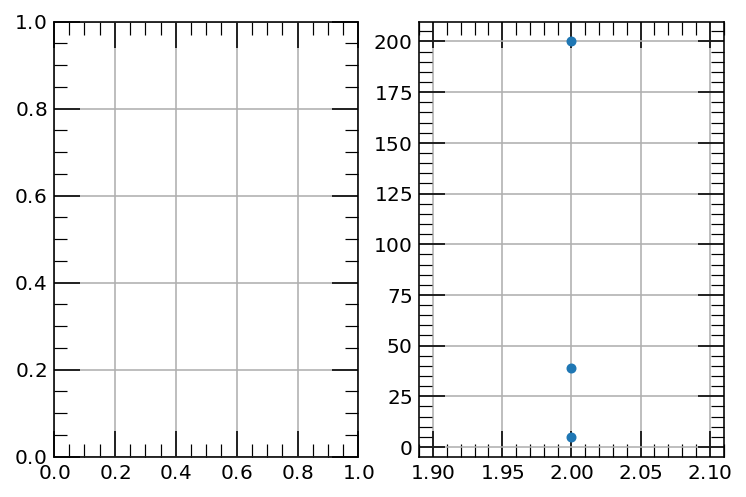

In [185]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

bins_pT_ls = []
division_ls = [2,3,4,5,6,7,8,9]

for divisions in division_ls:
    bins_pT, bin_stats_dict = find_equal_hist_divisions(bin_edges, bin_vals, divisions, verbose=False)
    bins_pT_ls.append(bins_pT)
    
for div,bin_ls in zip(division_ls, bins_pT_ls):

    x_vals = np.ones(len(bin_ls))*div

    ax2.plot(x_vals, bin_ls, linestyle="", label=r"$p_T$ bins")
    ax2.plot(K_ls, bin_ls)
    ax2.legend()
# ax1.plot(K_ls, perc_diff_ls)

In [184]:
bins_pT_ls

[[5.0, 39.0, 200.0]]

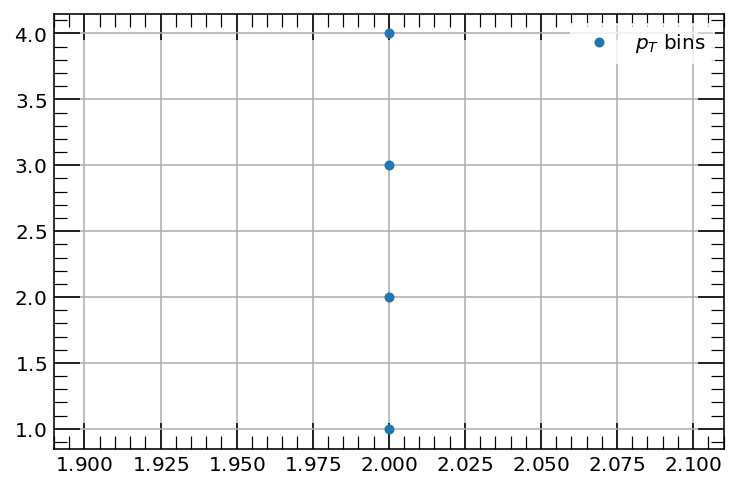

In [178]:
# prac_2D_arr = np.array([,[8,9,7,2]])

f,ax = plt.subplots()



In [164]:
bin_stats_dict

{'Division1': 5.244761421652867,
 'Division2': 4.521720257518737,
 'Division3': 6.034680738839543,
 'Division4': -0.5307349278094575,
 'Division5': -15.270427490201726}

In [ ]:

                      

    
    pdf_name  = f"{year}_{sample}_{bspv}__"
    title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
    # Example of Python magic: auto-concatenation of strings.
    pdf_name += (f"{title_str_pT_min}_pT_{pT_max}"
                 f"__{eta_min}_eta_{eta_max}"
                 f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}"
                 f"__wrt_{wrt}")
    pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
    
    outfile = os.path.join(outfile_path, pdf_name)
    if not os.path.exists(outfile_path):
        os.makedirs(outfile_path)
    if os.path.exists(outfile) and not (overwrite):
        print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
        return
        
    status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
    print(status)

            # Store info of this plot in a HistInfo object. 
            this_hist = HistInfo()            
            this_hist.year = year
            this_hist.sample = sample
            this_hist.bspv = bspv
            this_hist.d0_bin_window = [this_d0_bin, next_d0_bin]
            this_hist.x_axis_bounds_list = deltapT_range_ls[0:2] # 2-element list
            this_hist.eta_range = eta_cut_ls
            this_hist.pT_range = pT_cut_ls
            this_hist.massZ_cut = massZ_min
            this_hist.n_entries = n_entries
            this_hist.hist_mean = mean
            this_hist.hist_mean_err = mean_err
            this_hist.hist_stdev = stdev  # Spread of the data.
            this_hist.hist_stdev_err = stdev_err
            
            graph_info_ls.append(this_hist)
            
        return graph_info_ls


# Grids of 2D plots.

#### FIXME: 
- [ ] Use np.arrays to contain kbins for easy reshaping?
- [ ] Eventually merge into make_grid_of_2D_plots_FIXME.py

In [ ]:
%%time

n_evts = 10000

eta_bin_BARREL  = [0.0, 0.3]
eta_bin_OVERLAP = [0.8, 1.1]
eta_bin_ENDCAP  = [2.1, 2.4]


pT_bin_LOW1 = [5, 7]
pT_bin_LOW2 = [7, 10]
pT_bin_LOW3 = [10, 15]
pT_bin_LOW4 = [15, 20]
pT_bin_LOW5 = [20, 25]
pT_bin_LOW6 = [25, 30]

pT_bin_MED1 = [30, 35]
pT_bin_MED2 = [35, 40]
pT_bin_MED3 = [40, 45]
pT_bin_MED4 = [45, 50]
pT_bin_MED5 = [50, 55]
pT_bin_MED6 = [55, 60]

pT_bin_HIGH1 = [60, 65]
pT_bin_HIGH2 = [65, 70]
pT_bin_HIGH3 = [70, 75]
pT_bin_HIGH4 = [75, 80]
pT_bin_HIGH5 = [80, 90]
pT_bin_HIGH6 = [90, 100]

#--------------#
#--- Barrel ---#
#--------------#
# Low pT.
kbin_eta_BARREL_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# Med pT.
kbin_eta_BARREL_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_BARREL_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)


# #---------------#
# #--- Overlap ---#
# #---------------#
# # Low pT.
# kbin_eta_OVERLAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_OVERLAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_OVERLAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

# #---------------#
# #--- Endcap ---#
# #---------------#
# # Low pT.
# kbin_eta_ENDCAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_ENDCAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_ENDCAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

In [ ]:
dir(org_kbin)

In [ ]:
for key,val in org_kbin.__dict__.items():
    print("key is:", key, "   value is:", val)

In [ ]:
import matplotlib.pyplot as plt
from d0_Utils.d0_fns import calc_x_err_bins
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

class GraphLine():
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    def __init__(self, x_vals, y_vals, y_err_vals=np.zeros(0)):
        self.x_vals = x_vals
        self.y_vals = y_vals
#         self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
    def draw_graph(self, kinem_x, kinem_y, x_label="", y_label="", binning_type="", kbin_example=None, ax=None):
        """
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        """
        if binning_type not in ["eta", "pT"]:
            raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
#         #--- Check that things make sense: ---#
#         # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
#         wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
#         # Do same thing for binning in pT.
#         wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
#         if (wrong_eta_binning or wrong_pT_binning):
#             err_msg = f"\n\nBinning type ({binning_type}) specified, "
#             err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
#             raise RuntimeError(err_msg)
        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ecolor='k'
        ms=4  # marker size
        mec='k'  # marker edge color
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = label_LaTeX_dict[kinem_x]["independent_label"]
        if len(y_label) == 0:
            y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
            y_label += " (iterated Gaus fit mean)"
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
        low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        label_text = kbin_example.cut_dict[binning_type]
        ax.errorbar(self.x_vals, self.y_vals, xerr=[low_x_err, high_x_err], yerr=self.y_err_vals, fmt='.', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
        tmp_dict = kbin_example.cut_dict.copy()
        for key in list(kbin_example.cut_dict.keys()):
            if (binning_type in key) or ("d0" in key):
                del tmp_dict[key]
                    
        sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
        cut_str = combine_cut_list(sorted_cut_ls)
        textbox_text = cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        ax.text(0.025, 0.87, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
    def do_linear_fit(self, ax=None):
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8,9.6)) 
        
        # Do fit. 
        # Draw fit on axes.
        # return optimized parameters
        self.popt_linear = None

In [ ]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [ ]:
rescue_code()

In [ ]:
KinBin

In [ ]:
n_evts = 1000

# dataframe = pd.read_hdf('/Users/Jake/Desktop/MC_2016.h5')


massZ_cut_ls = [60,120]
d0q_cut_ls = [-0.01, 0.01]
d0_type = "BS"
dR_cut = 0.02
use_ptotal_instead = False
verbose = False

eta_regions = [
    [0.0, 0.3],
    [0.8, 1.1],
#     [2.1, 2.4]
]

# You should make there's always 18 different regions.
pT_regions = [
    [5, 7]  ,
    [7, 10] ,
    [10, 15],
    [15, 20],
    [20, 25],
#     [25, 30],
#     [30, 35],
#     [35, 40],
#     [40, 45],
#     [45, 50],
#     [50, 55],
#     [55, 60],
#     [60, 65],
#     [65, 70],
#     [70, 75],
#     [75, 80],
#     [80, 90],
#     [90, 100]
]

all_kbin_ls = []
for eta_reg in eta_regions:
    for pT_reg in pT_regions:
        all_kbin_ls.append( KinematicBin(df_MC_2016, n_evts, massZ_cut_ls, eta_reg, pT_reg, d0q_cut_ls, 
                                         d0_type, dR_cut, use_ptotal_instead, verbose) 
                          )

In [ ]:
kb1 = all_kbin_ls[0]
kb2 = all_kbin_ls[1]
kb3 = all_kbin_ls[2]

# First edition $dp_T/p_T^2$ vs. $d_0*q$ plotter

In [ ]:
def make_graph(*graph_tuple, binning_type='eta', verbose=False, save_plots=True, outpath='/Users/Jake/Desktop/'):
    """
    Make one deltapT vs. d0*charge plot, with as many graphs displayed as len(graph_tuple).
    graph_tuple contains many lists (graph_lsX) of histograms (HistInfo).
    
    graph_tuple = (
        graph_ls1,  # Each hist in this graph_ls all have identical cuts, but are made over different d0 bins.
        graph_ls2,  # This graph_ls2 may have slightly different cuts than graph_ls1.
        ...,
    )
    
    #--- Example ---#
    graph_ls1 = [HistInfo1, HistInfo2, ...]  # This list will generate 1 deltapT_vs_d0charge graph. 
    graph_ls2 = [HistInfo1, HistInfo2, ...]  # This list will generate another graph, but may have different cuts. 

    If binning_type is 'eta', then each graph_ls in graph_tuple should have the same pT cuts.
        This way, we can view different eta ranges while making sure pT cuts are all the same. 
    If binning_type is 'pT', then each graph_ls in graph_tuple should have the same eta cuts. 
    
    Returns
    -------
    graph_ls contains all the correct graph info to make a plot. 
    """    

        
    text_size_legend = 6
    text_size_ax_labels = 12
    text_size_tick_labels = 8
    text_size_title = 12


    # If binning in eta, then each graph should the same pT cuts. 
    if binning_type in 'eta':
        title_str += f'{example_graph.pT_range[0]}<' + r'$p_T$' + f'<{example_graph.pT_range[1]} GeV'
    elif binning_type in 'pT':
        title_str += f'{example_graph.eta_range[0]}<' + r'$\left| \eta \right|$' + f'<{example_graph.eta_range[1]}'
    ax.set_title(title_str)

    x_min = min([gr.d0_bin_window[0] for gr in example_graph_ls])
    x_max = max([gr.d0_bin_window[1] for gr in example_graph_ls])
    bin_edge_left = example_graph.d0_bin_window[0]
    bin_edge_right = example_graph.d0_bin_window[1]
    x_bin_width = abs(bin_edge_right - bin_edge_left)

    # ax.set_xlim([x_min*x_axis_scale, x_max*x_axis_scale])
    ax.set_xlim([-0.012, 0.012])
    ax.set_ylim([-0.005, 0.005])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
    # Gridlines.
    ax.grid(which='major',color='k', ls=':')

    x_bin_arr = np.arange(x_min, x_max+0.5*x_bin_width, x_bin_width)  # Includes all bin edges: very first to very last.
    x_n_bins = calc_num_bins(x_min, x_max, x_bin_width)

    # Calculate %diff for ratio plot.
    # acc_ZD_arr = np.array(acc_ZD, dtype=float)
    # acc_ALP_arr = np.array(acc_ALP, dtype=float)
    # acc_perc_diff_arr = (acc_ALP_arr - acc_ZD_arr) / acc_ZD_arr

    # Calculate errors on %diff.
    # acc_perc_diff_err_arr = getUncertOfFractionBinomial(acc_ALP_arr, acc_ZD_arr)

    # Plot the data.
    for count, gr_ls in enumerate(graph_tuple, 1):
        example_gr = gr_ls[0]
        y_vals = [gr.hist_mean for gr in gr_ls]
        y_vals_err = [gr.hist_mean_err for gr in gr_ls]
        if (verbose): 
            print(f'y_vals for graph_ls {count}:\n{y_vals}\n')

            
            
    
        plotname  = (f'deltapT_vs_d0{example_graph.bspv}timescharge_{example_graph.sample}{example_graph.year}_'
                     f'{binning_type}binning__')
        if binning_type in 'pT':
            plotname += f'{example_graph.eta_range[0]}_eta_{example_graph.eta_range[1]}'
        elif binning_type in 'eta':
            plotname += f'{example_graph.pT_range[0]}_pT_{example_graph.pT_range[1]}'
        plotname = make_str_title_friendly(plotname)
        
        fullpath = os.path.join(outpath, plotname)
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        plt.savefig(fullpath + '.pdf')
        plt.savefig(fullpath + '.png')
        print("Plot saved at:\n", fullpath)
    

# def make_kinem_comparison_plot(df, year, sample, 
# 
#     
#     pdf_name  = f"{year}_{sample}_"
#     title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
#     # Example of Python magic: auto-concatenation of strings.
#     pdf_name += (f"{kinem_gen}_vs_{kinem_rec}__{bspv}"
#                  f"__{title_str_pT_min}_pT_{pT_max}"
#                  f"__{eta_min_abs}_abs_eta_{eta_max_abs}"
#                  f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}")
#                 #  f"__wrt_{wrt}")
#     pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
#     
#     outfile = os.path.join(outfile_path, pdf_name)
#     if not os.path.exists(outfile_path):
#         os.makedirs(outfile_path)
#     if os.path.exists(outfile) and not (overwrite):
#         print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
#         return
#         
#     status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
#     print(status)
# 
# 
#         for k in range(len(d0_bin_arr)-1):
#             this_d0_bin = d0_bin_arr[k]
#             next_d0_bin = d0_bin_arr[k+1]
#             if bspv in 'BS':
#                 mask_d0BSxcharge = (this_d0_bin < d0BSxcharge_ser) & (d0BSxcharge_ser < next_d0_bin)
#                 # mask_d0BS2xcharge = (this_d0_bin < d0BS2xcharge_ser) & (d0BS2xcharge_ser < next_d0_bin)
#             elif bspv in 'PV':
#                 mask_d0PVxcharge = (this_d0_bin < d0PVxcharge_ser) & (d0PVxcharge_ser < next_d0_bin)
#                 # mask_d0PV2xcharge = (this_d0_bin < d0PV2xcharge_ser) & (d0PV2xcharge_ser < next_d0_bin)
# 
#                 
#  
#             # Store info of this plot in HistInfo objects. 
#             hist_gen = HistInfo()
#             hist_rec = HistInfo()            
#             hist_gen.year = year
#             hist_rec.year = year
#             hist_gen.sample = sample 
#             hist_rec.sample = sample
#             hist_gen.bspv = bspv 
#             hist_rec.bspv = bspv
#             hist_gen.d0_bin_window = [this_d0_bin, next_d0_bin] 
#             hist_rec.d0_bin_window = [this_d0_bin, next_d0_bin]
#             hist_gen.x_axis_bounds_list = x_range_ls[0:2] # 2-element list 
#             hist_rec.x_axis_bounds_list = x_range_ls[0:2] # 2-element list
#             hist_gen.eta_range = eta_cut_ls 
#             hist_rec.eta_range = eta_cut_ls
#             hist_gen.pT_range = pT_cut_ls
#             hist_rec.pT_range = pT_cut_ls
#             hist_gen.massZ_cut = massZ_min
#             hist_rec.massZ_cut = massZ_min
#             hist_gen.n_entries = n_entries_gen
#             hist_rec.n_entries = n_entries_rec
#             hist_gen.hist_mean = mean_gen
#             hist_rec.hist_mean = mean_rec
#             hist_gen.hist_mean_err = mean_err_gen
#             hist_rec.hist_mean_err = mean_err_rec
#             hist_gen.hist_stdev = stdev_gen
#             hist_rec.hist_stdev = stdev_rec  # Spread of the data.
#             hist_gen.hist_stdev_err = stdev_err_gen
#             hist_rec.hist_stdev_err = stdev_err_rec
#             
#             graph_info_gen_ls.append(hist_gen)
#             graph_info_rec_ls.append(hist_rec)
 

In [ ]:
%config InlineBackend.figure_format ='retina'

fig = plt.figure(figsize=(25.6,19.2))
ax = plt.subplot(221)
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 3))
ax = plt.subplot(222)
kbin.plot_1D_kinematics(kinem="delta_pToverRecpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))
ax = plt.subplot(223)
kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 4))
ax = plt.subplot(224)
kbin.plot_1D_kinematics(kinem="d0BSq2", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))

# Kinematics subplots.

In [ ]:
# kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.02, 0.02], bin_limits=[-0.008, 0.008, 0.0002], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))

In [ ]:
kbin.cut_dict.copy()

In [ ]:
play_dict.items()

In [ ]:
[key for key in play_dict.keys()]

In [ ]:
play_dict = {'a':1, 'b':2, 'c':4}

In [ ]:
graph_test.draw_graph("d0BSq1","delta_pToverpT1",kbin_example=kbin_ls[0])

In [ ]:
kbin.stats_dict

In [ ]:
graph_test.draw_graph("d0BSq1","delta_pToverpT1",kbin_example=kbin_ls[0])

In [ ]:
np.zeros(0)

In [ ]:
# hist_mean = kbin.stats_dict['delta_pToverpT1']['hist_stats'][1]
# hist_mean_err = kbin.stats_dict['delta_pToverpT1']['hist_stats'][2]
# fit_mean = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1]
# fit_mean_err = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1]

d0_bin_arr, d0_bin_width = make_binning_array(d0_bin_limits)
d0_bin_arr_shifted = shift_binning_array(d0_bin_arr)

if d0_bin_width < 0.0005:
    err_msg = f"WARNING: d0_bin_width ({d0_bin_width}) is too small (d0_bin_width < 0.0005).\nStopping now."
    raise ValueError(err_msg)    

# Make list of kinematic bins.
kbin_ls = []
with PdfPages(outpath) as pdf:
    for elem in range(len(d0_bin_arr)-1):
        # Make a kbin for each d0 bin.
        d0_this = d0_bin_arr[elem]
        d0_next = d0_bin_arr[elem+1]

        kbin = KinematicBin(df_MC_2016, 
                            n_evts=n_evts_scan, 
                            massZ_cut_ls=[60,120],
                            eta_cut_ls=[0.0, 0.3], 
                            pT_cut_ls=[40, 50], 
                            d0q_cut_ls=[d0_this, d0_next],
                            d0_type='BS',
                            dR_cut=0.02,
                            use_ptotal_instead=False, 
                            verbose=True)
        kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
        kbin_ls.append(kbin)
        
        pdf.savefig()
        plt.close()

# Get graph values.
hist_mean_ls     = []
hist_mean_err_ls = []
fit_mean_ls      = []
fit_mean_err_ls  = []
for kb in kbin_ls:
    hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
    hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
    fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
    fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])

al=1  # alpha=0 is transparent
elw=1  # error bar line width
ecolor='k'
ms=4  # marker size
mec='k'  # marker edge color
cs=1  # cap size
mew=0.7  # marker edge width

low_x_err, high_x_err = calc_x_err_bins(d0_bin_arr_shifted)
    
fig, ax = plt.subplots(figsize=(12.8,9.6))

# legend_text = ""
# ax.text(k, y, "Some words", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#             legend_text = f'{example_gr.pT_range[0]} <' + r' $p_T$ ' + f'< {example_gr.pT_range[1]}'
ax.errorbar(d0_bin_arr_shifted, fit_mean_ls, xerr=[low_x_err, high_x_err], 
            yerr=fit_mean_err_ls, fmt='s', label="some cuts go here?",
        #color=color_dict[count], 
            elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
ax.legend(loc='upper left', framealpha=al)#, fontsize=text_size_legend)